In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

# Entrainment rate in the F4 run (1536^3)

We add up the amount of the entrained fluid present in the convection zone and the amount that must have burnt (assuming that all of the burning takes place in the convection zone). The burning rate is calculated from the YProfile data.

In [2]:
import time
import utils
from ppm import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib nbagg
import astronomy as ast
%load_ext autoreload
%autoreload 2
from scipy import interpolate as interpolate

yprof = yprofile('/rpod2/PPM/YProfiles/AGBTP_M2.0Z1.e-5/F4')

Q = 1.944*1.60218e-6/1e43
RR = 8.3144598
amu = 1.66054e-24/1e27

airmu = 1.39165
cldmu = 0.725
fkair = 0.203606102635
fkcld = 0.885906040268
AtomicNoair = 6.65742024965
AtomicNocld = 1.34228187919

atomicnocldinv = 1./AtomicNocld
atomicnoairinv = 1./AtomicNoair

cb = utils.colourblind

patience0 = 5
patience = 10

/usr/local/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Reading attributes from file  YProfile-01-1959.bobaaa
Analyzing headers ...
There are 1960 YProfile files in the /rpod2/PPM/YProfiles/AGBTP_M2.0Z1.e-5/F4 directory.
Ndump values range from 0 to 1959
Time values range from 86.5493 to 162264.0


In [3]:
def cdiff(x):
            dx = 0.5*(np.roll(x, -1) - np.roll(x, +1))
            dx[0] = dx[1]
            dx[-1] = dx[-2]

            return dx

In [ ]:
dumps = np.array(range(0, 1350, 1))
nd = len(dumps)
t = np.zeros(nd)
L_H = np.zeros(nd)

t00 = time.time()
t0 = t00
k = 0
for i in range(nd):
    t[i] = yprof.get('t', fname = dumps[i], resolution = 'l')[-1]
    
    if dumps[i] >= 620:
        L_H[i] = yprof.get('L_C12pg', fname = dumps[i], resolution = 'l', airmu = airmu, \
                           cldmu = cldmu, fkair = fkair, fkcld = fkcld, AtomicNoair = AtomicNoair, \
                           AtomicNocld = AtomicNocld, corr_fact = 1.0)
    else:
        L_H[i] = 0.
    
    t_now = time.time()
    if (t_now - t0 >= patience) or \
       ((t_now - t00 < patience) and (t_now - t00 >= patience0) and (k == 0)):
        time_per_dump = (t_now - t00)/float(i + 1)
        time_remaining = (nd - i - 1)*time_per_dump
        print 'Processing will be done in {:.0f} s.'.format(time_remaining)
        t0 = t_now
        k += 1

ndot = L_H/Q
X_H = fkcld*1./AtomicNocld
mdot_L = 1.*amu*ndot/X_H
dt = cdiff(t)
m_HHe_burnt = (1e27/ast.msun_g)*np.cumsum(mdot_L*dt)        

m_HHe_present = yprof.entrainment_rate(dumps, 27.7, 28.5, var='vxz', criterion='min_grad', offset=-1., \
                integrate_both_fluids=False, show_output=False, return_time_series=True)

<IPython.core.display.Javascript object>


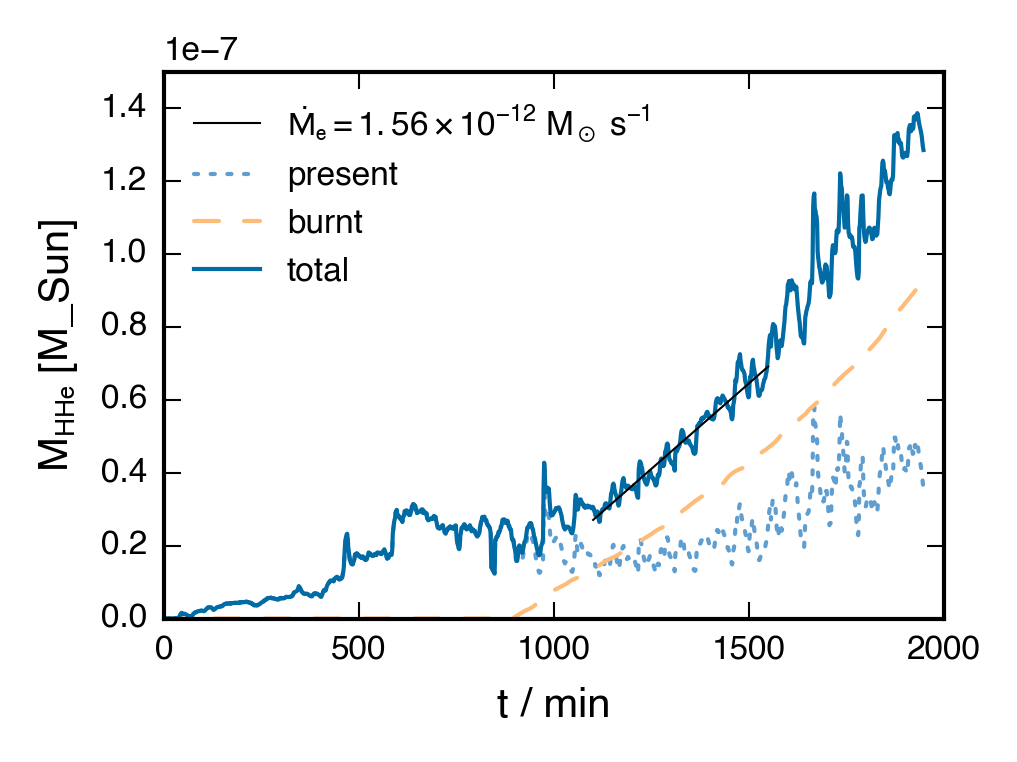

In [5]:
m_HHe_total = m_HHe_present + m_HHe_burnt

idx1 = range(0, np.argmin(dumps < 616))
m_HHe_total_fc1 = np.polyfit(t[idx1], m_HHe_total[idx1], 1)
m_HHe_total_fit1 = m_HHe_total_fc1[0]*t[idx1] + m_HHe_total_fc1[1]

mdot1 = m_HHe_total_fc1[0]
mdot1_str = '{:e}'.format(mdot1)
parts = mdot1_str.split('e')
mantissa = float(parts[0])
exponent = int(parts[1])
lbl1 = r'$\dot{{\mathrm{{M}}}}_\mathrm{{e}} = {:.2f} \times 10^{{{:d}}}$ M$_\odot$ s$^{{-1}}$'.\
      format(mantissa, exponent)

idx2 = range(np.argmin(t/60. < 1100), np.argmin(t/60. < 1550))
m_HHe_total_fc2 = np.polyfit(t[idx2], m_HHe_total[idx2], 1)
m_HHe_total_fit2 = m_HHe_total_fc2[0]*t[idx2] + m_HHe_total_fc2[1]

mdot2 = m_HHe_total_fc2[0]
mdot2_str = '{:e}'.format(mdot2)
parts = mdot2_str.split('e')
mantissa = float(parts[0])
exponent = int(parts[1])
lbl2 = r'$\dot{{\mathrm{{M}}}}_\mathrm{{e}} = {:.2f} \times 10^{{{:d}}}$ M$_\odot$ s$^{{-1}}$'.\
      format(mantissa, exponent)
    
ifig = 1; plt.close(ifig); plt.figure(ifig)
#plt.plot(t[idx1]/60., m_HHe_total_fit1, '--', color = 'k', lw = 0.5, \
#         zorder = 101, label = lbl1)
plt.plot(t[idx2]/60., m_HHe_total_fit2, '-', color =  'k', lw = 0.5, \
         zorder = 102, label = lbl2)
plt.plot(t/60., m_HHe_present, ':', color = cb(3), label = 'present')
plt.plot(t/60., m_HHe_burnt, '--', color = cb(6), label = 'burnt')
plt.plot(t/60., m_HHe_total, '-', color = cb(5), label = 'total')
plt.xlabel('t / min')
plt.ylabel(r'M$_\mathrm{HHe}$ [M_Sun]')
plt.xlim((0., 2000.))
plt.ylim((0., 1.5e-7))
plt.gca().ticklabel_format(style='sci', scilimits=(0,0), axis='y')
plt.legend(loc = 0)
plt.tight_layout()
plt.savefig('entrainment_rate_F4_b.pdf')